In [1]:
import copy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle

In [2]:
my_map = [[0]*5 for _ in range(5)]
my_map[2][0] = 'Rs'
my_map[2][2] = 'Rd'
my_map[1][1] = -1
my_map[2][1] = -1
my_map[1][3] = -1
my_map[2][3] = -1
my_map[4][0] = 'Rw'
my_map[4][1] = 'Rw'
my_map[4][2] = 'Rw'
my_map[4][3] = 'Rw'
my_map[4][4] = 'Rw'

In [3]:
# this function plots a map with various ways
# given my_map, it plots the map: plot_map(my_map)
# given my_map, positions (trajectory)， it will plot it on the map: plot_map(my_map, [[0,0], [0,1], [0,2], [1,2]] )
# given my_map, positions, observations, it will plot the trajectory with the oservation: plot_map(my_map, [[0,0], [0,1], [0,2], [1,2]], [1,2,3,4])
# given my_map, values (same size with map), it will plot the values. This can be used to show action/value
def plot_map(my_map, positions=[], observations=[], values=[]):
    # draw the grid frame
    n = len(my_map)
    m = len(my_map[0])
    fig,ax = plt.subplots(figsize=(6, 6))
    
    # draw the whole grid
    for x,row in enumerate(my_map):
        for y,element in enumerate(row):
            if type(element)==type(0) and element == -1:
                ax.add_patch(Rectangle((x,y),1,1,color='lightgray'))
                ax.text(x+0.4,y+0.4,str('X'),c='black',size='xx-large')
            elif type(element)==type('str'):
                if element == 'Rw':
                    ax.add_patch(Rectangle((x,y),1,1,color='red'))
                    if len(values) == 0:
                        ax.text(x+0.35,y+0.4,element,c='black',size='xx-large')
                else:
                    ax.add_patch(Rectangle((x,y),1,1,color='lime'))
                    if len(values) == 0:
                        ax.text(x+0.35,y+0.4,element,c='black',size='xx-large')                   
    
    # if need rewards
    if len(values) > 0:
        for x,row in enumerate(my_map):
            for y,element in enumerate(row):
                if type(element)==type(0) and element == -1:
                    pass
                else:
                    ax.text(x+0.15,y+0.4,'{:.2f}'.format(values[x][y]),c='black',size='xx-large')
    else:
        # draw arrows of start
        if len(positions) > 0:
            ax.add_patch(Circle((positions[0][0]+0.5, positions[0][1]+0.5), 0.05, color='blue'))
            ax.text(positions[0][0]+0.05, positions[0][1]+0.2,'0',c='black',size='small') 
            if len(observations) > 0:
                ax.text(positions[0][0]+0.05, positions[0][1]+0.7, str(observations[0]),c='gray',size='small') 

        # draw all the movements
        max_num = len(positions)
        for num, pos in enumerate(positions[1:]):
            ax.add_patch(Circle((pos[0]+0.5, pos[1]+0.5), 0.05+0.15*(num+1)/max_num, color='blue'))
            ax.text(pos[0]+0.05+0.9*(num+1)/max_num, pos[1]+0.2, str(num+1), c='black', size='small') 
            if len(observations) == max_num:
                ax.text(pos[0]+0.05+0.9*(num+1)/max_num, pos[1]+0.7, str(observations[num+1]),c='gray',size='small') 
    
    # some configs
    plt.xticks(np.arange(n+1))
    plt.yticks(np.arange(m+1))

    ax.set_xticklabels([str(x) for x in np.arange(n+1)])
    ax.set_yticklabels([str(y) for y in np.arange(m+1)])
    
    plt.grid()
    plt.show()

In [4]:
moves_map = {0:[0,0], 1:[-1,0], 2:[0,1], 3:[1,0], 4:[0,-1]}
# this function receive a position and action and return next position with correct randomness
def move_one_step(my_map, pos, move, pe, n, m):
    # if already stop/ never
    #if type(my_map[pos[0]][pos[1]]) == type('str'):
    #    return pos
    
    # else choose the random action
    actions = [(1-pe)/(len(moves_map)-1)] * len(moves_map)
    actions[move] = pe
    action = np.argmax(np.random.multinomial(1, actions))
    movement = moves_map[action]
    # next pois
    next_pos =[pos[0]+movement[0], pos[1]+movement[1]]
    
    # if not valid: out the map
    if next_pos[0] < 0 or next_pos[0] >= n:
        return pos
    if next_pos[1] < 0 or next_pos[1] >= m:
        return pos
    
    # else if target is obstacle
    if type(my_map[next_pos[0]][next_pos[1]]) == type(0) and my_map[next_pos[0]][next_pos[1]] == -1:
        return pos
    
    return next_pos


# given a set of moves: [0,1,1,0,1], it will move with randomness
def move(my_map, start, moves, pe):
    n = len(my_map)
    m = len(my_map[0])
    
    # find Rs, Rd
    for i in range(n):
        for j in range(m):
            if my_map[i][j] == 'Rs':
                rs_pos = [i,j]
            if my_map[i][j] == 'Rd':
                rd_pos = [i,j]
    
    # start and obs
    positions = [start]
    pos = start
    d_s = ((rs_pos[0]-pos[0])**2+(rs_pos[1]-pos[1])**2)**0.5
    d_d = ((rd_pos[0]-pos[0])**2+(rd_pos[1]-pos[1])**2)**0.5
    h = 2/((d_s+0.001)**(-1)+(d_d+0.0001)**(-1))
    p = 1-(np.ceil(h) - h)
    if np.random.rand() <= p:
        o = np.ceil(h)
    else:
        o = np.floor(h)
    observations = [int(o)]
    
    # move
    for move in moves:
        pos = move_one_step(my_map, pos, move, pe, n, m)
        positions.append(pos)
        
        d_s = ((rs_pos[0]-pos[0])**2+(rs_pos[1]-pos[1])**2)**0.5
        d_d = ((rd_pos[0]-pos[0])**2+(rd_pos[1]-pos[1])**2)**0.5
        h = 2/((d_s+0.001)**(-1)+(d_d+0.0001)**(-1))
        p = 1-(np.ceil(h) - h)
        if np.random.rand() <= p:
            o = np.ceil(h)
        else:
            o = np.floor(h)
        observations.append(int(o))
    
    return positions, observations, [p, h]

In [8]:
pe=0.9

In [9]:
n = len(my_map)
m = len(my_map[0])
p_o = np.zeros([n*m, 5])
p_s = [np.zeros([n*m,n*m]) for i in range(len(moves_map))]

In [10]:
for s in range(n*m):
    i = int(s/m)
    j = s%m
    if type(my_map[i][j]) == type(-1) and  my_map[i][j] == -1:
        pass
    else:
        _,_, t = move(my_map, [i,j], [], pe)
        p_o[s, int(np.ceil(t[1]))] = t[0]
        p_o[s, int(np.floor(t[1]))] = 1-t[0]

In [11]:
for action, p_state in enumerate(p_s):
    for s in range(n*m):
        i = int(s/m)
        j = s%m
        if type(my_map[i][j]) == type(-1) and  my_map[i][j] == -1:
            pass
        else:
            action_prob = [(1-pe)/4]*5
            action_prob[action] = pe
            next_states = [[i,j], [i-1, j], [i,j+1],[i+1,j],[i,j-1]]
            
            # next state
            for a,next_s in enumerate(next_states):
                if next_s[0]== -1 or next_s[0]==n or next_s[1]== -1 or next_s[1]==m:
                    action_prob[0] = action_prob[0] + action_prob[a]
                    action_prob[a] = 0
                else:
                    if type(my_map[next_s[0]][next_s[1]]) == type(-1) and  my_map[next_s[0]][next_s[1]] == -1:
                        action_prob[0] = action_prob[0] + action_prob[a]
                        action_prob[a] = 0
                        
                               
            
            for a,next_s in enumerate(next_states):
                if action_prob[a] == 0:
                    pass
                else:
                    p_state[i*n+j, next_s[0]*n + next_s[1]] = action_prob[a]

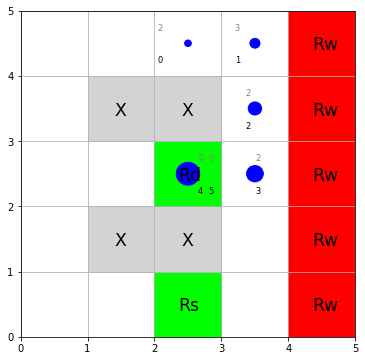

In [19]:
start = [2,4]
moves = [3,4,4,1,0]
p, o,_ = move(my_map, start, moves, pe=0.9)
plot_map(my_map, p, o)

In [75]:
moves

[3, 4, 4, 1, 0]

In [74]:
o

[2, 3, 2, 2, 0, 0]

In [70]:
s0 = np.zeros([n*m, 1])
s0[start[0] * n + start[1]] = 1

In [71]:
i = 0
s0 = p_o[:, [o[i]]] * s0 / (p_o[:, [o[i]]] * s0).sum()
for i in range(len(moves)):
    s0 = p_s[moves[i]].T.dot(s0)
    s0 = p_o[:, [o[i+1]]] * s0 / (p_o[:, [o[i+1]]] * s0).sum()

In [72]:
s0

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [73]:
np.argmax(s0)

12